<a href="https://colab.research.google.com/github/Ay-slim/Hamoye/blob/master/StageD_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHAOFAWhwYypmtWWHAK-RwE3K1fO3XWEQY58ABSGrTLd0f3IghVz7s
Mounted at /content/gdrive


In [ ]:
#Create environment
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
#Go to kaggle directory 
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#check present working directory
! pwd

/content/gdrive/My Drive/Kaggle


In [ ]:
#download dataset
!kaggle datasets download -d nikitarom/planets-dataset

100% 1.49G/1.50G [00:20<00:00, 53.8MB/s]
100% 1.50G/1.50G [00:20<00:00, 78.1MB/s]


In [ ]:
#List files in directory
!ls

kaggle.json  planets-dataset.zip  test-jpg-additional


In [ ]:
#Unzip zipped files
!unzip \*.zip  #&& rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_551.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fil

In [1]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import time
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Load csv files
df_train = pd.read_csv('/content/drive/My Drive/Kaggle/planet/planet/train_classes.csv')
df_test = pd.read_csv('/content/drive/My Drive/Kaggle/planet/planet/sample_submission.csv')

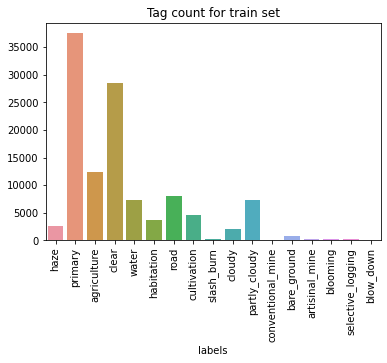

In [5]:
#Explore distribution of train labels
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1
tag_list=list(counts.keys()) 
y=list(counts.values())
sns.barplot(x=tag_list, y=y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag count for train set');

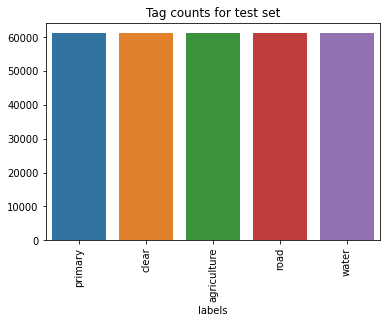

In [7]:
#Explore distribution of test labels
labels_test = df_test['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts_test = defaultdict(int)
for l in labels_test:
    for l2 in l:
        counts_test[l2] += 1
tag_list_test=list(counts_test.keys()) 
test_count=list(counts_test.values())
sns.barplot(x=tag_list_test, y=test_count);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag counts for test set');

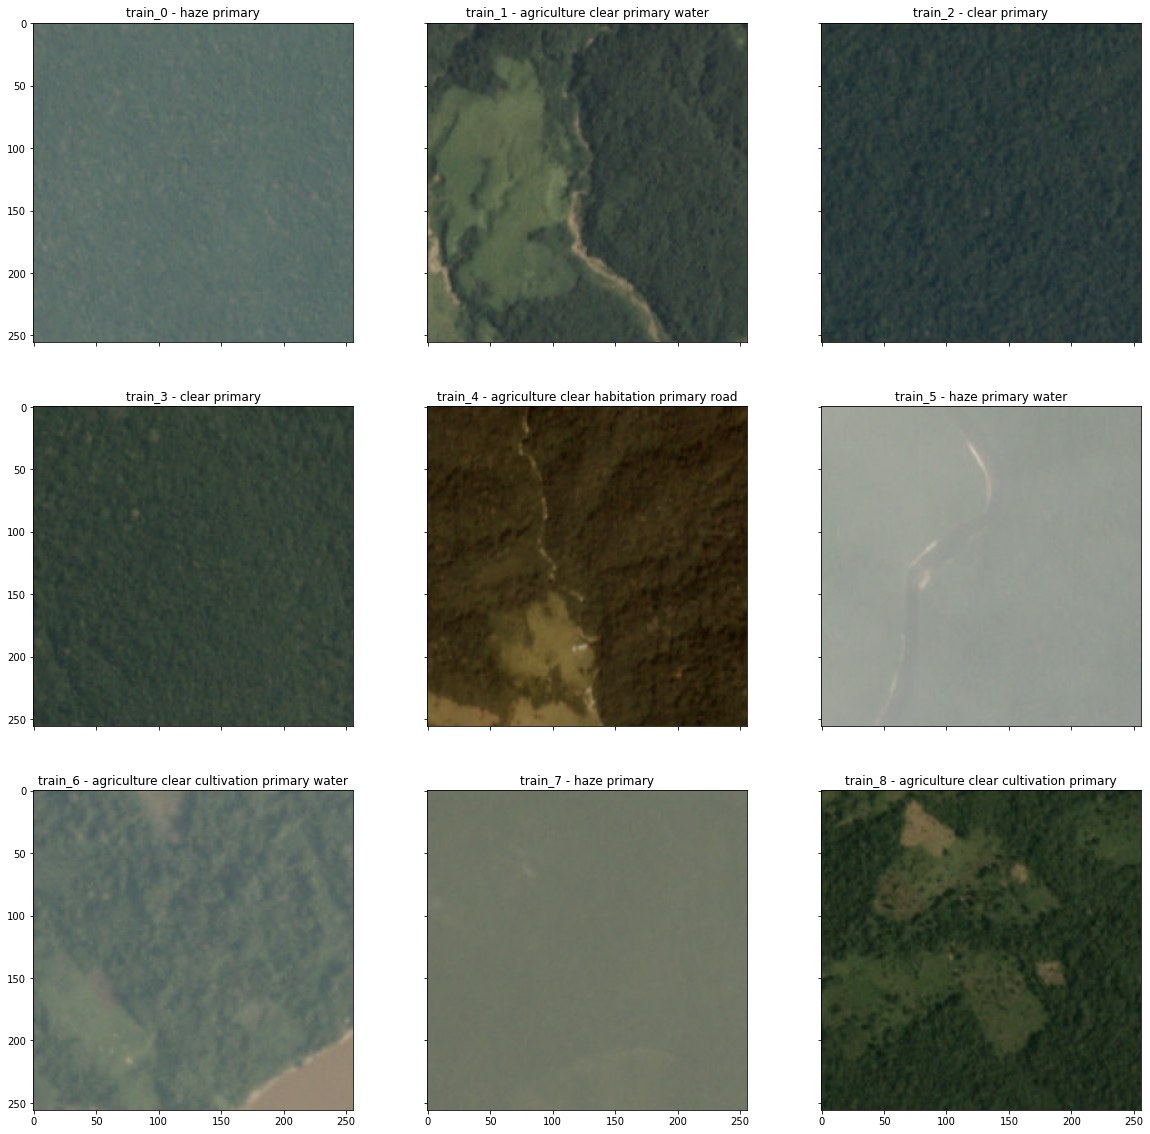

In [ ]:
#Display some train images
import cv2

new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread('/content/gdrive/My Drive/Kaggle/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

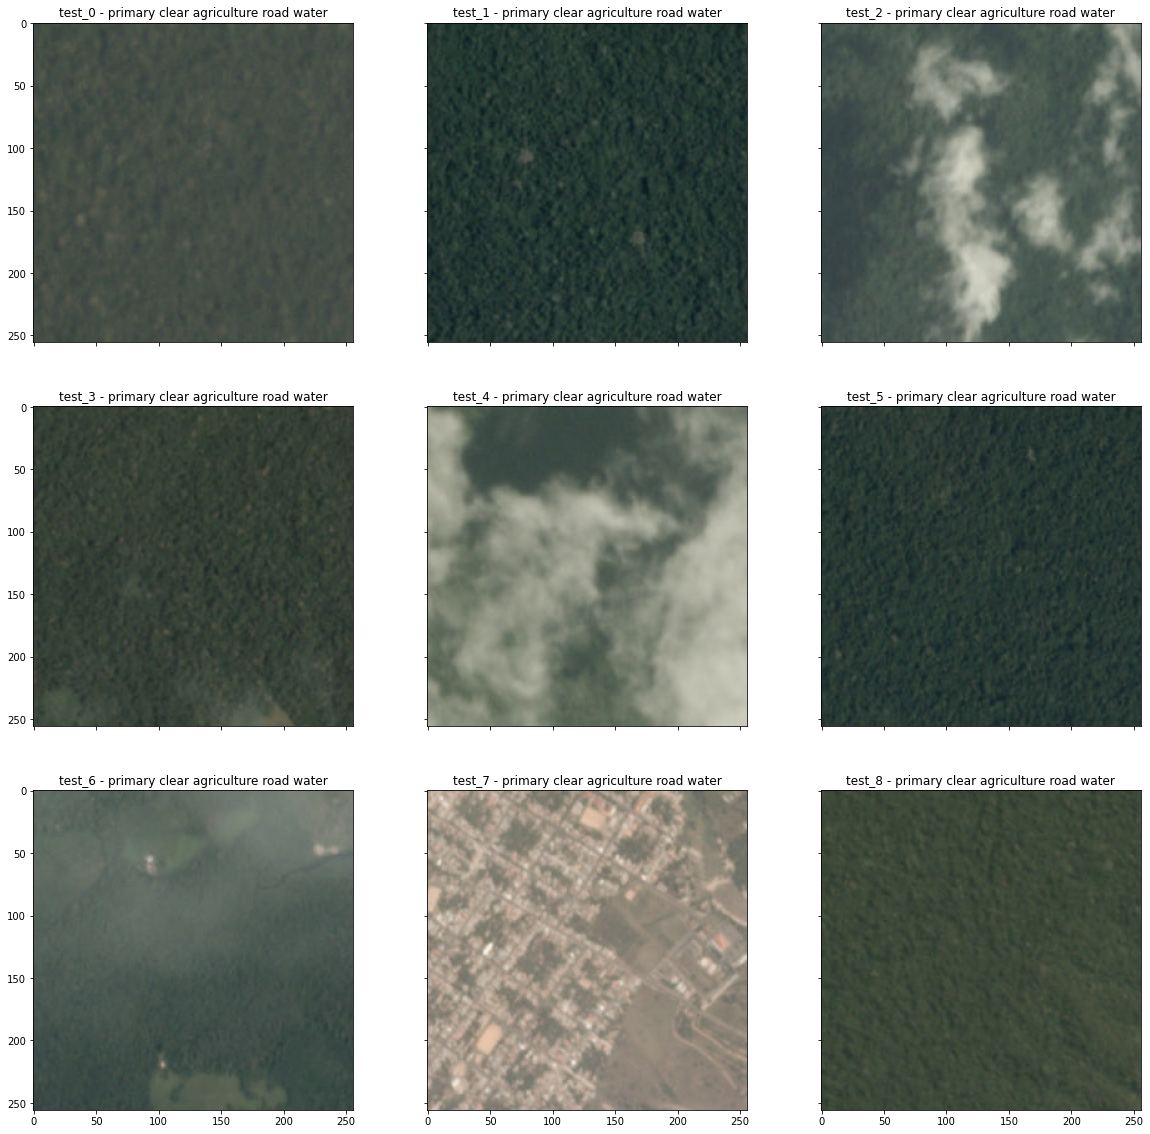

In [ ]:
#Display some test images
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_test[:9].values:
    img = cv2.imread('/content/gdrive/My Drive/Kaggle/planet/planet/test-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

In [8]:
#Create a dictionary assigning unique numbers to each label
label_map = {i:j for j, i in enumerate(tag_list)}
label_map

{'agriculture': 2,
 'artisinal_mine': 13,
 'bare_ground': 12,
 'blooming': 14,
 'blow_down': 16,
 'clear': 3,
 'cloudy': 9,
 'conventional_mine': 11,
 'cultivation': 7,
 'habitation': 5,
 'haze': 0,
 'partly_cloudy': 10,
 'primary': 1,
 'road': 6,
 'selective_logging': 15,
 'slash_burn': 8,
 'water': 4}

In [ ]:
# Resize training images and assign labels 
X_train, Y_train = [], []
for img, label in df_train.values:
  target = np.zeros(17)
  for tag in label.split(' '):
    target[label_map[tag]]=1
  X_train.append(cv2.resize(cv2.imread('/content/drive/My Drive/Kaggle/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
  Y_train.append(target)

In [ ]:
#Resize test images
X_test=[]
for img, label in tqdm(df_test[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/gdrive/My Drive/Kaggle/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))


100%|██████████| 40669/40669 [03:23<00:00, 199.64it/s]


In [ ]:
#Resize additional test images
for img, label in tqdm(df_test[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/gdrive/My Drive/Kaggle/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))

100%|██████████| 20522/20522 [01:29<00:00, 229.62it/s]


In [ ]:
#Check dimensions
len(X_test), len(X_train), len(Y_train)

(61191, 40479, 40479)

In [ ]:
#Change lists to numpy arrays and normalize
x_train = np.array(X_train, np.float16)/255
y_train = np.array(Y_train, np.uint8)
x_test = np.array(X_test, np.float16)/255
#split the train data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

In [ ]:
#Write a function to calculate the fbeta score
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
    y_pred = K.clip(y_pred, 0, 1)
    y_pred_bin = K.round(y_pred + threshold_shift)
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

#Train a network with 2 convolution layers, 2 pooling layers, 1 fully connected layer, and one output layer.
model = keras.Sequential()
model.add(Conv2D(64, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(17, activation = "sigmoid"))
#train the model
model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = [fbeta])
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, batch_size = 128)

In [ ]:
predictions = model.predict(x_test, batch_size = 128) #Make predictions on the test set
pred = pd.DataFrame(predictions, columns =  tag_list) #Create a data frame of predictions with the tags as column names

#Write a loop to assign each value to its predicted label
preds = []
for i in tqdm(range(pred.shape[0]), miniters=1000):
    a = pred.iloc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [ ]:
df_test['tags'] = preds #Assign the predictions to the tags column of the df_test data frame
df_test.to_csv('Submission.csv', index = False) #Export to csv